<a href="https://colab.research.google.com/github/elisabethelen/T2_DeepLearning/blob/main/202255202026_T2_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task Klasifikasi Gambar
Menggunakan objek Piring dengan 4 kelas diantaranya Piring Kaca, Piring Plastik, Piring Melamin, Piring Keramik**

***Mount Google Drive***

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Import Necessary Libraries***

In [ ]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

In [ ]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# Path ke dataset
data_path = "/content/drive/MyDrive/dataset"

***Load and Transform Data***

In [ ]:
# Data Transformasi
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Load dataset
full_dataset = datasets.ImageFolder(data_path, transform=transform['train'])
class_names = full_dataset.classes

In [ ]:
# Split train, val, test (70/15/15)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
val_set.dataset.transform = transform['val_test']
test_set.dataset.transform = transform['val_test']

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

***Placing Data into a Dataframe***

In [42]:
import pandas as pd

# Ambil list semua file dan label dari ImageFolder
image_paths = [s[0] for s in full_dataset.samples]
labels = [class_names[s[1]] for s in full_dataset.samples]

# Buat DataFrame
df = pd.DataFrame({
    'filename': image_paths,
    'label': labels
})

# Tampilkan 5 baris pertama
print(df.head())

                                            filename     label
0  /content/drive/MyDrive/dataset/keramik /IMG202...  keramik 
1  /content/drive/MyDrive/dataset/keramik /IMG202...  keramik 
2  /content/drive/MyDrive/dataset/keramik /IMG202...  keramik 
3  /content/drive/MyDrive/dataset/keramik /IMG202...  keramik 
4  /content/drive/MyDrive/dataset/keramik /IMG202...  keramik 


***Visualizing images from the dataset***

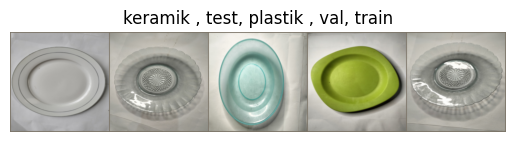

In [ ]:
# Tampilkan sample gambar

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Fungsi untuk menampilkan gambar
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Ambil satu gambar dari masing-masing kelas
def get_one_sample_per_class(dataloader, class_names):
    samples = {}
    for images, labels in dataloader:
        for img, lbl in zip(images, labels):
            class_name = class_names[lbl.item()]
            if class_name not in samples:
                samples[class_name] = (img, class_name)
            if len(samples) == len(class_names):
                break
        if len(samples) == len(class_names):
            break
    return samples

# Contoh penggunaan:
samples = get_one_sample_per_class(train_loader, class_names)

# Siapkan gambar dan label
images = [img for img, _ in samples.values()]
titles = [lbl for _, lbl in samples.values()]

# Buat grid dan tampilkan
imshow(make_grid(images), title=", ".join(titles))

***Model Preparation dan Modifikasi***

In [ ]:
# Load model ResNet18 dan modifikasi classifier
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze pretrained layers

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [ ]:
# Custom classifier
# Get the number of features from the last layer before your custom classifier
# Since model.fc is a Linear object, access in_features directly
num_ftrs = model.fc.in_features
# Assuming you have 5 classes instead of 4 based on the error message
num_classes = len(class_names)  # Get the actual number of classes from your dataset
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, num_classes)  # Update the output layer to match the number of classes
)
model = model.to(device)

In [ ]:
# Loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

***Training the model***

In [18]:
# Training model
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 1.1311 | Val Loss: 0.5136 | Val Acc: 0.9000
Epoch 2/50 | Train Loss: 0.6344 | Val Loss: 0.3721 | Val Acc: 0.9000
Epoch 3/50 | Train Loss: 0.5175 | Val Loss: 0.3459 | Val Acc: 0.9000
Epoch 4/50 | Train Loss: 0.4967 | Val Loss: 0.3884 | Val Acc: 0.8833
Epoch 5/50 | Train Loss: 0.4941 | Val Loss: 0.3426 | Val Acc: 0.9000
Epoch 6/50 | Train Loss: 0.4711 | Val Loss: 0.3272 | Val Acc: 0.9000
Epoch 7/50 | Train Loss: 0.4849 | Val Loss: 0.3179 | Val Acc: 0.9000
Epoch 8/50 | Train Loss: 0.4405 | Val Loss: 0.3275 | Val Acc: 0.9000
Epoch 9/50 | Train Loss: 0.4267 | Val Loss: 0.3109 | Val Acc: 0.9000
Epoch 10/50 | Train Loss: 0.4495 | Val Loss: 0.3371 | Val Acc: 0.8833
Epoch 11/50 | Train Loss: 0.4459 | Val Loss: 0.3176 | Val Acc: 0.8944
Epoch 12/50 | Train Loss: 0.4481 | Val Loss: 0.3079 | Val Acc: 0.9000
Epoch 13/50 | Train Loss: 0.4227 | Val Loss: 0.3318 | Val Acc: 0.8944
Epoch 14/50 | Train Loss: 0.4175 | Val Loss: 0.3295 | Val Acc: 0.8889
Epoch 15/50 | Train Loss: 0.4

***Visualizing loss curves***

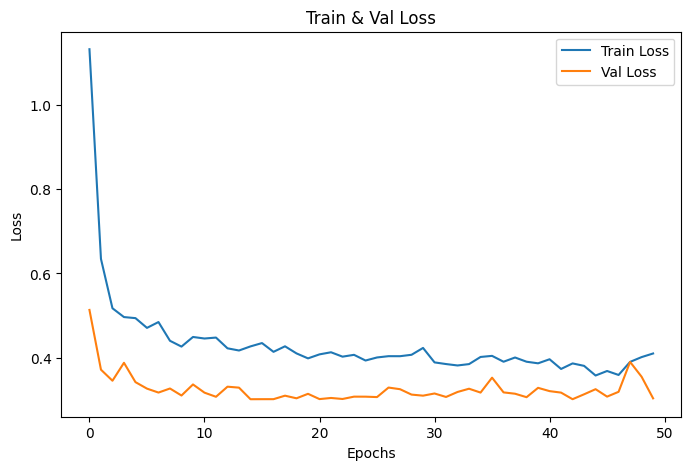

In [19]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Train & Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

***Making predictions on the Test Data***

In [20]:
# Evaluasi Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 84.44%


***Model Evaluation***

              precision    recall  f1-score   support

    keramik        1.00      1.00      1.00        51
    plastik        1.00      1.00      1.00        45
        test       0.00      0.00      0.00        15
       train       0.67      1.00      0.80        56
         val       0.00      0.00      0.00        13

    accuracy                           0.84       180
   macro avg       0.53      0.60      0.56       180
weighted avg       0.74      0.84      0.78       180



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


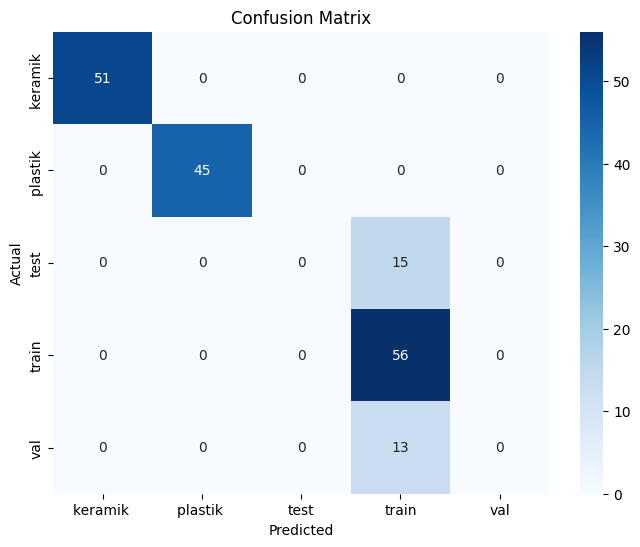

In [31]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

***Computing Error Rate Analysis***

In [44]:
# Error Rate Analysis
test_error_rate = 1 - test_acc
print(f"Test Error Rate: {test_error_rate*100:.2f}%")

Test Error Rate: 15.56%


***Grad-Cam Visualization***

In [39]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

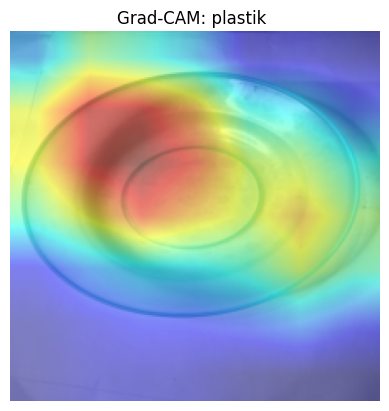

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
# Ambil satu gambar dari test set
image_tensor, label = test_set[0]
input_tensor = image_tensor.unsqueeze(0).to(device)

# Ubah tensor jadi numpy image
rgb_image = image_tensor.permute(1, 2, 0).cpu().numpy()
rgb_image = (rgb_image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
rgb_image = np.clip(rgb_image, 0, 1)

# Aktifkan grad untuk input
input_tensor.requires_grad = True

# Ubah model ke mode train sementara untuk Grad-CAM
model.train()

# Tentukan target layer (layer terakhir sebelum FC)
target_layers = [model.layer4[-1]]

# Inisialisasi Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers)

# Tentukan target prediksi
targets = [ClassifierOutputTarget(label)]

# Jalankan CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # ambil pertama dari batch

# Visualisasi
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Grad-CAM: {class_names[label]}")
plt.axis("off")
plt.show()

# Kembalikan model ke eval() setelah selesai
model.eval()

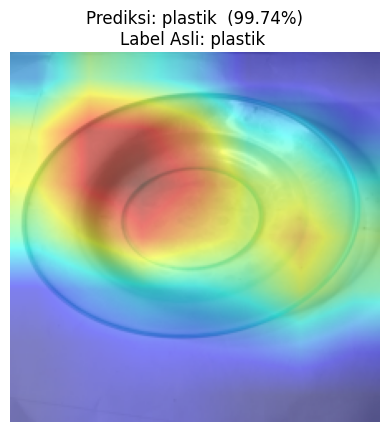

In [41]:
import torch.nn.functional as F

# Ambil 1 sample dari test set
image, label = test_set[0]
input_tensor = image.unsqueeze(0).to(device)

# Buat RGB image asli dari tensor
rgb_image = image.permute(1, 2, 0).cpu().numpy()
rgb_image = (rgb_image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
rgb_image = np.clip(rgb_image, 0, 1)

# Pastikan model aktif untuk autograd
model.train()
input_tensor.requires_grad = True

# Target layer Grad-CAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Prediksi dulu
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    pred_confidence = probs[0][pred_class].item()

# Grad-CAM untuk kelas yang diprediksi
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Gabungkan CAM dengan gambar asli
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# Tampilkan hasil
plt.imshow(visualization)
plt.axis("off")
plt.title(
    f"Prediksi: {class_names[pred_class]} ({pred_confidence*100:.2f}%)\n"
    f"Label Asli: {class_names[label]}"
)
plt.show()